# Flow Matching 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/flow_matching_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a flow-matching model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and likelihood estimation.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [1]:
# Load autoreload extension for development convenience
%load_ext autoreload
%autoreload 2

In [2]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [3]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples

In [4]:
# Set training and model restoration flags
overwrite_model = False
restore_model = False  # Use pretrained model if available
train_model = True  # Set to True to train from scratch

### Library Imports and JAX Backend Selection

In [5]:
# Import libraries and set JAX backend
import os
os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
# os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/flow_matching_2d_example_1b"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [7]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45

    return data

In [8]:
# # Infinite data generator for training batches
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_boxes_jax(key, batch_size)

#     return x

data = make_boxes_jax(jax.random.PRNGKey(0), 500_000)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
)

performance_config = grain.experimental.pick_performance_config(
            ds=train_dataset_grain,
            ram_budget_mb=1024 * 4,
            max_workers=None,
            max_buffer_size=None,
        )

train_dataset_batched = train_dataset_grain.batch(512).mp_prefetch(
            performance_config.multiprocessing_options
        )

train_iter = iter(train_dataset_batched)

data_val = make_boxes_jax(jax.random.PRNGKey(1), 1000)

val_dataset_batched = (
    grain.MapDataset.source(np.array(data_val)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(512)
)

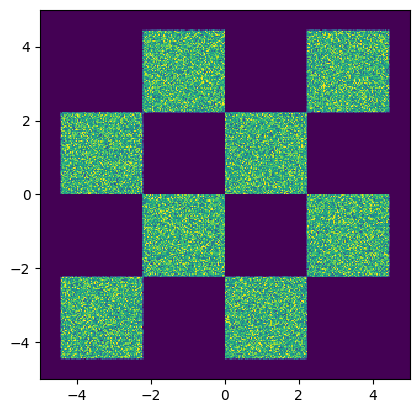

In [9]:
# Visualize the generated data distribution
samples = np.array(data)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the flow-matching model.

In [10]:
# Import flow matching components and utilities
from gensbi.recipes import JointFlowPipeline

/home/zaldivar/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Define the MLP velocity field model
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, t: jax.Array, obs: jax.Array,  **kwargs):
        assert obs.ndim == 3, f"Input obs must have shape (batch_size, input_dim, 1), got {obs.shape}"
        t = jnp.atleast_1d(t)
        x = jnp.squeeze(obs, axis=-1)
        if t.ndim<2:
            t = t[..., None]

        t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x[...,None]

In [12]:
# Initialize the velocity field model
hidden_dim = 512

# velocity field model init
model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

training_config = JointFlowPipeline._get_default_training_config()
training_config["checkpoint_dir"] = checkpoint_dir


pipeline = JointFlowPipeline(model,
    train_dataset_batched,
    val_dataset_batched,
    2,
    0,
    params=None,
    training_config=training_config)

In [13]:
# Restore the model from checkpoint if requested
if restore_model:
    pipeline.restore_model()

## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [14]:
if train_model:
    # Train the model
    pipeline.train(nnx.Rngs(0), nsteps=10_000)

100%|██████████| 10000/10000 [01:22<00:00, 121.00it/s, counter=0, loss=3.8100, ratio=1.0363, val_loss=3.9484]


Saved model to checkpoint


## 5. Sampling from the Model

In this section, we sample trajectories from the trained flow-matching model and visualize the results at different time steps.

### sample the model

In [25]:
key = jax.random.PRNGKey(42)
T = jnp.linspace(0,1,10)  # sample times
sol = pipeline.sample(key, nsamples=500_000, time_grid=T)

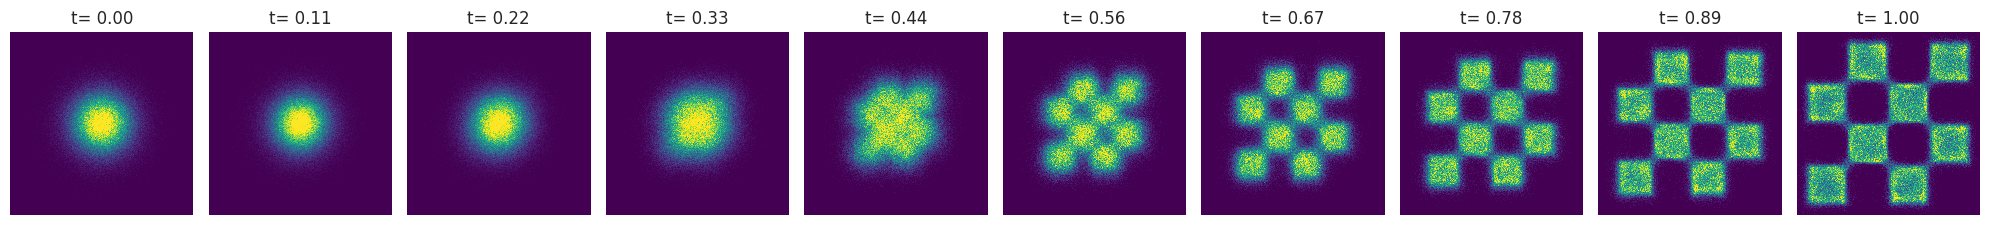

In [26]:
# Visualize the sampled trajectories at different time steps
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
plt.show()

## 6. Marginal and Trajectory Visualization

We visualize the marginal distributions and sample trajectories from the model.

In [27]:
# Import plotting utility for marginals
from gensbi.utils.plotting import plot_marginals

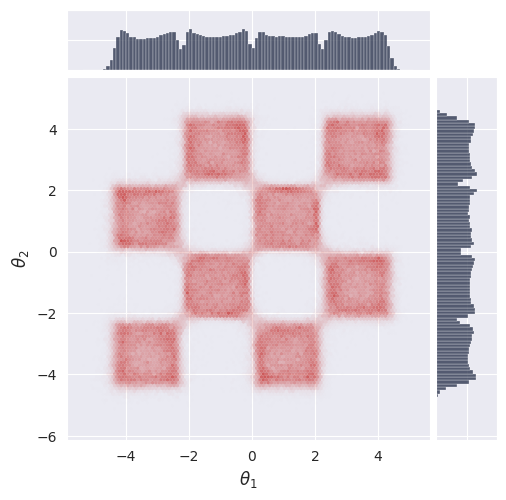

In [28]:
# Plot the marginal distribution of the final samples
plot_marginals(sol[-1], plot_levels=False, gridsize=100, backend="seaborn")
plt.show()

In [29]:
# Sample and visualize trajectories with finer time resolution
batch_size = 1000
T = jnp.linspace(0,1,50)  # sample times

sol = pipeline.sample(key, nsamples=batch_size, time_grid=T)

In [30]:
# Import plotting utility for trajectories
from gensbi.utils.plotting import plot_trajectories

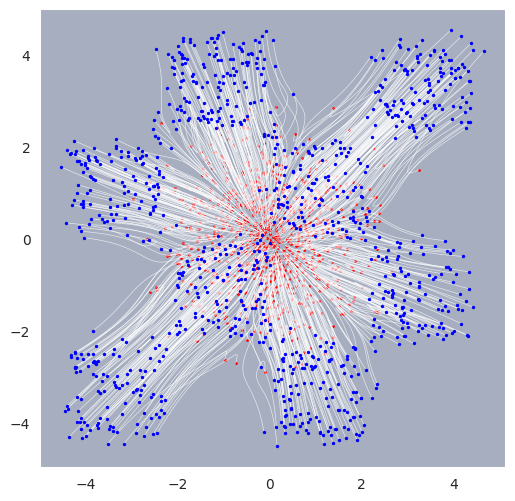

In [31]:
# Plot sampled trajectories
fig, ax = plot_trajectories(sol)
plt.grid(False)
plt.show()

## 7. Likelihood Estimation

This section demonstrates how to estimate and visualize the likelihood of the model on a grid of points in 2D space.

### sample the likelihood

In [35]:
# Prepare grid for likelihood evaluation
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-5, 5, grid_size), jnp.linspace(-5, 5, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [36]:
exact_log_p= pipeline.compute_unnorm_logprob(x_1, step_size=0.01, use_ema=True)

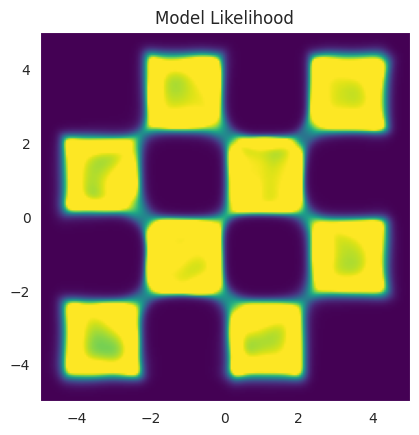

In [37]:
# Visualize the model likelihood on the 2D grid
likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

cmin = 0
cmax = 1/40.5 # the domain goes from -4.5 to 4.5. The total area is (4.5*2)**2. Since only half of the area is covered by the data likelihood, we divide by 2 -> (4.5*2)**2 / 2 = 40.5. As Such 1/40.5 is the max theoretical likelihood value
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

# Create the figure and axis objects explicitly
fig, ax = plt.subplots()

likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
ax.set_title('Model Likelihood')

plt.grid(False)
plt.show()